This is a implement of classification dogs_and_cats using transfer learning <br>
The dataset can be downloaded here:https://www.kaggle.com/c/dogs-vs-cats/data

In [1]:
import os
import shutil
import cv2
import matplotlib.pyplot as plt
import numpy as np

import keras
from keras import models
from keras.layers import Dense, Dropout, Flatten, Activation, Lambda, Conv2D, MaxPooling2D, Input
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model

Using TensorFlow backend.


To prevent segmentation error or kernel dead

In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.InteractiveSession(config=config)

In [3]:
pwd = os.getcwd()

Refer to https://github.com/PacktPublishing/Deep-Learning-for-Computer-Vision/tree/master/Chapter02

divide train/test dataset

In [4]:
def copy_files(prefix_str, range_start, range_end, target_dir):
    image_paths = [os.path.join(pwd, 'train', prefix_str + '.' + str(i) + '.jpg')
                   for i in range(range_start, range_end)]
    # imgae_paths : path/train/dog.0.jpg
    # imgae_paths : path/train/cat.0.jpg
    
    # target_dir : 'train' or 'test' 
    # prefix_str :'dog' or 'cat'
    # save_dir : path/data/train/dog, path/data/train/cat
    # path/data/test/dog, path/data/test/cat
    save_dir = os.path.join(pwd, 'data', target_dir, prefix_str)
    if not os.path.exists(save_dir): # if there is no exist, make the path
        os.makedirs(save_dir)
    
    # copy image to save_dir
    for image_path in image_paths:
        shutil.copy(image_path, save_dir)

In [5]:
copy_files('dog', 0, 1000, 'train')
copy_files('cat', 0, 1000, 'train')
copy_files('dog', 1000, 1400, 'test')
copy_files('cat', 1000, 1400, 'test')

# Data Preprocessing

In [6]:
print(os.listdir('./data'))

['test', 'train']


In [7]:
train_dog = [os.path.join(pwd, 'data', 'train', 'dog', 'dog' + '.' + str(i) + '.jpg')
                   for i in range(1000)]
test_dog = [os.path.join(pwd, 'data', 'test', 'dog', 'dog'+ '.' + str(i) + '.jpg')
                   for i in range(1000, 1400)]

train_cat = [os.path.join(pwd, 'data', 'train', 'cat', 'cat' + '.' + str(i) + '.jpg')
                   for i in range(1000)]
test_cat = [os.path.join(pwd, 'data', 'test', 'cat', 'cat' + '.' + str(i) + '.jpg')
                   for i in range(1000, 1400)]

(375, 499, 3)


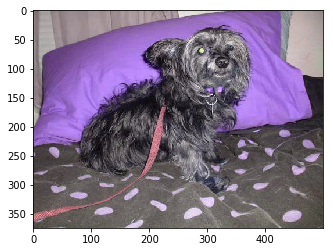

In [8]:
dog = cv2.imread(train_dog[0], cv2.IMREAD_UNCHANGED)
plt.imshow(dog)
print(dog.shape)

Resize image

In [9]:
IMG_W, IMG_H = 128, 128

In [10]:
x_train_dog = np.empty((len(train_dog), IMG_H, IMG_W, 3), dtype=np.float32)
x_train_cat = np.empty((len(train_cat), IMG_H, IMG_W, 3), dtype=np.float32)
x_test_dog =  np.empty((len(test_dog), IMG_H, IMG_W, 3), dtype=np.float32)
x_test_cat =  np.empty((len(test_cat), IMG_H, IMG_W, 3), dtype=np.float32)

In [11]:
def load_data_dog_cat(img_path, dataX):
    for i, image in enumerate(img_path):

        img = cv2.imread(image, cv2.IMREAD_UNCHANGED)
        img = cv2.resize(img, dsize=(IMG_W, IMG_H))
       
        dataX[i] = img

In [12]:
load_data_dog_cat(train_dog, x_train_dog)
load_data_dog_cat(train_cat, x_train_cat)
load_data_dog_cat(test_dog, x_test_dog)
load_data_dog_cat(test_cat, x_test_cat)

In [13]:
x_train = np.concatenate((x_train_dog, x_train_cat), axis = 0)

In [14]:
x_train.shape

(2000, 128, 128, 3)

In [15]:
x_test = np.concatenate((x_test_dog, x_test_cat), axis = 0)
x_test.shape

(800, 128, 128, 3)

Dog = 1, Cat = 0

In [16]:
y_train = np.concatenate((np.ones(1000), np.zeros(1000))).reshape(-1,1)

In [17]:
y_train.shape

(2000, 1)

In [18]:
y_test = np.concatenate((np.ones(400), np.zeros(400))).reshape(-1,1)

In [19]:
y_test.shape

(800, 1)

In [20]:
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

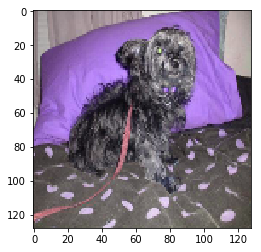

In [21]:
plt.imshow(x_train[0].astype('int32'))

# Load VGG16 model

In [22]:
from keras.applications.vgg16 import VGG16
vgg16_original = VGG16(weights = 'imagenet', include_top = False, input_shape = x_train[0].shape)

print(vgg16_original.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

Check list of layer

In [23]:
layer_dict = dict([(layer.name, layer) for layer in vgg16_original.layers])

In [24]:
layer_dict

{'block1_conv1': <keras.layers.convolutional.Conv2D at 0x7f296042f4e0>,
 'block1_conv2': <keras.layers.convolutional.Conv2D at 0x7f296042f9e8>,
 'block1_pool': <keras.layers.pooling.MaxPooling2D at 0x7f296041a668>,
 'block2_conv1': <keras.layers.convolutional.Conv2D at 0x7f296041a2e8>,
 'block2_conv2': <keras.layers.convolutional.Conv2D at 0x7f29603fe2e8>,
 'block2_pool': <keras.layers.pooling.MaxPooling2D at 0x7f29604115f8>,
 'block3_conv1': <keras.layers.convolutional.Conv2D at 0x7f2960411ac8>,
 'block3_conv2': <keras.layers.convolutional.Conv2D at 0x7f29603bc208>,
 'block3_conv3': <keras.layers.convolutional.Conv2D at 0x7f29603d23c8>,
 'block3_pool': <keras.layers.pooling.MaxPooling2D at 0x7f296036d438>,
 'block4_conv1': <keras.layers.convolutional.Conv2D at 0x7f296036de10>,
 'block4_conv2': <keras.layers.convolutional.Conv2D at 0x7f2960398198>,
 'block4_conv3': <keras.layers.convolutional.Conv2D at 0x7f296032d1d0>,
 'block4_pool': <keras.layers.pooling.MaxPooling2D at 0x7f296034655

Trainable option

In [25]:
for vgg_layer in vgg16_original.layers[:]:
    vgg_layer.trainable = False
    
for layer in vgg16_original.layers:
    print(layer, layer.trainable)    

<keras.engine.input_layer.InputLayer object at 0x7f296048ad30> False
<keras.layers.convolutional.Conv2D object at 0x7f296042f4e0> False
<keras.layers.convolutional.Conv2D object at 0x7f296042f9e8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f296041a668> False
<keras.layers.convolutional.Conv2D object at 0x7f296041a2e8> False
<keras.layers.convolutional.Conv2D object at 0x7f29603fe2e8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f29604115f8> False
<keras.layers.convolutional.Conv2D object at 0x7f2960411ac8> False
<keras.layers.convolutional.Conv2D object at 0x7f29603bc208> False
<keras.layers.convolutional.Conv2D object at 0x7f29603d23c8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f296036d438> False
<keras.layers.convolutional.Conv2D object at 0x7f296036de10> False
<keras.layers.convolutional.Conv2D object at 0x7f2960398198> False
<keras.layers.convolutional.Conv2D object at 0x7f296032d1d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f2960346550>

In [26]:
layer_end = layer_dict['block5_pool'].output

In [27]:
# vgg_model1 = Flatten()(vgg16_original.output)
vgg_model1 = Flatten()(layer_end)
vgg_model1 = Dense(512, activation = 'relu', kernel_initializer = 'he_normal')(vgg_model1)
vgg_model1 = Dense(256, activation = 'relu', kernel_initializer = 'he_normal')(vgg_model1)
vgg_model1 = Dense(2, activation = 'softmax')(vgg_model1)

custom_model1 = Model(inputs = vgg16_original.input, outputs = vgg_model1)

custom_model1.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = 0.001), metrics = ['accuracy'])

In [28]:
print(custom_model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [29]:
batch_size = 16
epoch = 5

In [30]:
train_gen = ImageDataGenerator(
                rescale = 1./255,
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                horizontal_flip=True)

In [31]:
test_gen = ImageDataGenerator(
                rescale = 1./255)

In [32]:
train_generator = train_gen.flow(
                x_train,
                y_train,
                batch_size = batch_size)

In [33]:
test_generator = test_gen.flow(
                x_test,
                y_test,
                batch_size = batch_size)

In [34]:
history = custom_model1.fit_generator(train_generator,
                steps_per_epoch = x_train.shape[0] // batch_size,
                epochs = epoch,
                validation_data = test_generator)

Epoch 1/5
125/125 [==============================] - 8s 60ms/step - loss: 0.5508 - acc: 0.7500 - val_loss: 0.3506 - val_acc: 0.8350
Epoch 2/5
125/125 [==============================] - 6s 45ms/step - loss: 0.3809 - acc: 0.8265 - val_loss: 0.3484 - val_acc: 0.8475
Epoch 3/5
125/125 [==============================] - 6s 45ms/step - loss: 0.3499 - acc: 0.8485 - val_loss: 0.2669 - val_acc: 0.8888
Epoch 4/5
125/125 [==============================] - 6s 46ms/step - loss: 0.3215 - acc: 0.8590 - val_loss: 0.2651 - val_acc: 0.8925
Epoch 5/5
125/125 [==============================] - 6s 45ms/step - loss: 0.3293 - acc: 0.8555 - val_loss: 0.2699 - val_acc: 0.8812


## Fine tuning VGG 16model : update feature extraction layers

In [35]:
vgg16_fine_model = VGG16(weights = 'imagenet', include_top = False, input_shape = x_train[0].shape)

Only train end of convolution layer and Maxpooling layer

In [36]:
for vgg_layer in vgg16_fine_model.layers[:-2]:
    vgg_layer.trainable = False
    
for layer in vgg16_fine_model.layers:
    print(layer, layer.trainable)    

<keras.engine.input_layer.InputLayer object at 0x7f29601b7208> False
<keras.layers.convolutional.Conv2D object at 0x7f29601b7588> False
<keras.layers.convolutional.Conv2D object at 0x7f296022ccc0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f29585806a0> False
<keras.layers.convolutional.Conv2D object at 0x7f29585803c8> False
<keras.layers.convolutional.Conv2D object at 0x7f296023fa90> False
<keras.layers.pooling.MaxPooling2D object at 0x7f29585d9080> False
<keras.layers.convolutional.Conv2D object at 0x7f29585d90b8> False
<keras.layers.convolutional.Conv2D object at 0x7f29585caa90> False
<keras.layers.convolutional.Conv2D object at 0x7f29585c3470> False
<keras.layers.pooling.MaxPooling2D object at 0x7f29586378d0> False
<keras.layers.convolutional.Conv2D object at 0x7f29586373c8> False
<keras.layers.convolutional.Conv2D object at 0x7f295862fa58> False
<keras.layers.convolutional.Conv2D object at 0x7f2958628898> False
<keras.layers.pooling.MaxPooling2D object at 0x7f29585f7f98>

In [37]:
layer_dict = dict([(layer.name, layer) for layer in vgg16_fine_model.layers])

In [38]:
layer_dict

{'block1_conv1': <keras.layers.convolutional.Conv2D at 0x7f29601b7588>,
 'block1_conv2': <keras.layers.convolutional.Conv2D at 0x7f296022ccc0>,
 'block1_pool': <keras.layers.pooling.MaxPooling2D at 0x7f29585806a0>,
 'block2_conv1': <keras.layers.convolutional.Conv2D at 0x7f29585803c8>,
 'block2_conv2': <keras.layers.convolutional.Conv2D at 0x7f296023fa90>,
 'block2_pool': <keras.layers.pooling.MaxPooling2D at 0x7f29585d9080>,
 'block3_conv1': <keras.layers.convolutional.Conv2D at 0x7f29585d90b8>,
 'block3_conv2': <keras.layers.convolutional.Conv2D at 0x7f29585caa90>,
 'block3_conv3': <keras.layers.convolutional.Conv2D at 0x7f29585c3470>,
 'block3_pool': <keras.layers.pooling.MaxPooling2D at 0x7f29586378d0>,
 'block4_conv1': <keras.layers.convolutional.Conv2D at 0x7f29586373c8>,
 'block4_conv2': <keras.layers.convolutional.Conv2D at 0x7f295862fa58>,
 'block4_conv3': <keras.layers.convolutional.Conv2D at 0x7f2958628898>,
 'block4_pool': <keras.layers.pooling.MaxPooling2D at 0x7f29585f7f9

In [39]:
layer_end = layer_dict['block5_pool'].output

In [40]:
vgg_fine_tune_model1 = Flatten()(layer_end)
vgg_fine_tune_model1 = Dense(512, activation = 'relu', kernel_initializer = 'he_normal')(vgg_fine_tune_model1)
vgg_fine_tune_model1 = Dense(256, activation = 'relu', kernel_initializer = 'he_normal')(vgg_fine_tune_model1)
vgg_fine_tune_model1 = Dense(2, activation = 'softmax')(vgg_fine_tune_model1)

vgg_fine_tune_model1  = Model(inputs = vgg16_fine_model.input, outputs = vgg_fine_tune_model1)

vgg_fine_tune_model1.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = 0.001), metrics = ['accuracy'])

In [41]:
print(vgg_fine_tune_model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [42]:
history = vgg_fine_tune_model1.fit_generator(train_generator,
                steps_per_epoch = x_train.shape[0] // batch_size,
                epochs = epoch,
                validation_data = test_generator)

Epoch 1/5
125/125 [==============================] - 6s 50ms/step - loss: 0.4977 - acc: 0.7925 - val_loss: 0.2734 - val_acc: 0.8725
Epoch 2/5
125/125 [==============================] - 6s 47ms/step - loss: 0.2971 - acc: 0.8770 - val_loss: 0.2280 - val_acc: 0.9150
Epoch 3/5
125/125 [==============================] - 6s 48ms/step - loss: 0.2711 - acc: 0.8870 - val_loss: 0.2551 - val_acc: 0.9000
Epoch 4/5
125/125 [==============================] - 6s 45ms/step - loss: 0.2483 - acc: 0.8980 - val_loss: 0.2467 - val_acc: 0.8975
Epoch 5/5
125/125 [==============================] - 6s 45ms/step - loss: 0.2342 - acc: 0.8975 - val_loss: 0.2537 - val_acc: 0.8988


## Using Resnet and Densnet is same pattern above

#### You need to change the input shape depending on the network type

In [ ]:
from keras.applications.resnet50 import ResNet50
resnet_model = ResNet50(weights = 'imagenet', include_top = False)

resnet_model1 = Flatten()(resnet_model.output)
resnet_model1 = Dense(512, activation = 'relu', kernel_initializer = 'he_normal')(resnet_model1)
resnet_model1 = Dense(256, activation = 'relu', kernel_initializer = 'he_normal')(resnet_model1)
resnet_model1 = Dense(2, activation = 'softmax')(resnet_model1)

resnet_model1 = Model(inputs = resnet_model.input, outputs = resnet_model1)
resnet_model1.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = 0.001), metrics = ['accuracy'])

history = resnet_model1.fit_generator(train_generator,
                steps_per_epoch = x_train.shape[0] // batch_size,
                epochs = epoch,
                validation_data = test_generator)

In [ ]:
from keras.applications.densenet import DenseNet121
dense_net = DenseNet121(weights = 'imagenet', include_top = False)